The goal of this notebook is to verify the formulas obtained for the marginal Shapley values and TreeSHAP for the two simple decision trees appearing in Example 3.1 of the paper (features are indexed as $X_0$ and $X_1$ here while as $X_1$ and $X_2$ in the paper). 

In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import os


import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

import shap

import catboost
from catboost import CatBoostRegressor, Pool

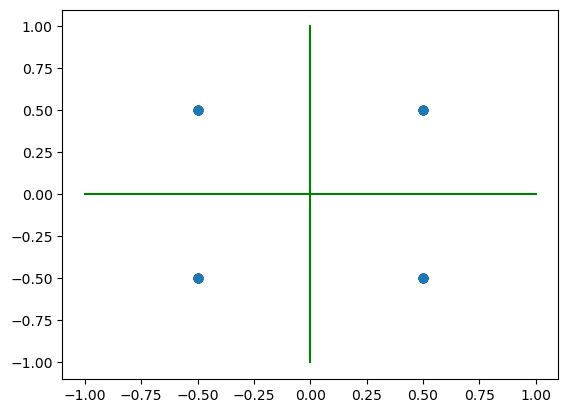

In [2]:
#Generating and visualizing the data
X=np.zeros([100,2])

for i in range(0,30):
    X[i][0]=(10**(-8))*(random.random()-0.5)-0.5
    X[i][1]=(10**(-8))*(random.random()-0.5)-0.5
for i in range(30,55):
    X[i][0]=(10**(-8))*(random.random()-0.5)+0.5
    X[i][1]=(10**(-8))*(random.random()-0.5)-0.5
for i in range(55,85):
    X[i][0]=(10**(-8))*(random.random()-0.5)-0.5
    X[i][1]=(10**(-8))*(random.random()-0.5)+0.5
for i in range(85,100):
    X[i][0]=(10**(-8))*(random.random()-0.5)+0.5
    X[i][1]=(10**(-8))*(random.random()-0.5)+0.5

plt.plot((-1,1),(0,0),'g')
plt.plot((0,0),(-1,1),'g')
plt.scatter(X[:,0],X[:,1])
plt.show()

In [3]:
#Values for the response variable
y=np.zeros([100,1])
for i in range(0,100):
    if X[i][1]<0:
        y[i]=1
    elif X[i][0]<0:
        y[i]=2
    else:
        y[i]=3

We start with an asymmetric decision tree. 

[Text(0.4, 0.8333333333333334, 'x[1] <= 0.0\nsquared_error = 0.54\nsamples = 100\nvalue = 1.6'),
 Text(0.2, 0.5, 'squared_error = 0.0\nsamples = 55\nvalue = 1.0'),
 Text(0.6, 0.5, 'x[0] <= 0.0\nsquared_error = 0.222\nsamples = 45\nvalue = 2.333'),
 Text(0.4, 0.16666666666666666, 'squared_error = 0.0\nsamples = 30\nvalue = 2.0'),
 Text(0.8, 0.16666666666666666, 'squared_error = 0.0\nsamples = 15\nvalue = 3.0')]

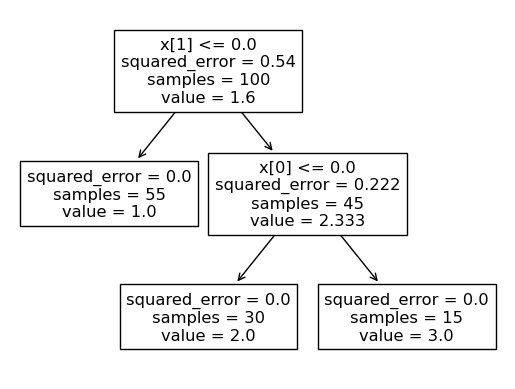

In [4]:
#Training a decision tree
dt=DecisionTreeRegressor(random_state=1)
dt.fit(X,y)

#Visualizing the tree
tree.plot_tree(dt)

We next compute interventional and path-dependent TreeSHAP feature attributions directly.

In [5]:
p1=0.55            #(=p1l+p1r)
p1l=0.3            #(the probability of ending up at the bottom left square)
p1r=0.25           #(the probability of ending up at the bottom right square)
p2=0.3             #(the probability of ending up at the top left square)
p3=0.15            #(the probability of ending up at the top right square)
c1=1               #(leaf value for the bottom squares)   
c2=2               #(leaf value for the top left square)
c3=3               #(leaf value for the top right square)
mean=p1*c1+p2*c2+p3*c3

def TreeSHAP(X):                                #Computing TreeSHAP feature attribution for X_0 directly
    if X[1]<0 and X[0]<0:                       #(Compare with Table 1 in the paper.)
        difference=(p2+p3)*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p2+p3)*(c3-c1)
    elif X[0]<0:
        difference=p1*c1+(p2+p3)*c2-(p2*c2+p3*c3)/(p2+p3)
    else:
        difference=p1*c1+(p2+p3)*c3-(p2*c2+p3*c3)/(p2+p3)
    return 0.5*(difference+dt.predict(X.reshape(1,2))-mean)     

def Marginal(X):
    if X[1]<0 and X[0]<0:
        difference=(p2+p3)*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p2+p3)*(c3-c1)
    elif X[0]<0:
        difference=(c1-c2)*p1+(c2-c3)*(p1r+p3)
    else:
        difference=(c1-c3)*p1+(c3-c2)*(p1l+p2)
    return 0.5*(difference+dt.predict(X.reshape(1,2))-mean)  

Comparing the SHAP package's output with our direct computation for the asymmetric tree.

In [6]:
#Path-dependent and marginal coincide on the lower rectangle, see Table 1 of the paper.
sample=np.asarray([2*random.random()-1,random.random()])
print(f'Sample point {sample}')

#path-dependent TreeSHAP
explainer=shap.TreeExplainer(dt,feature_perturbation='tree_path_dependent')
print(f'\npath-dependent attribution for X_0 at the sample point:\nfrom the package: {explainer.shap_values(sample)[0]}, computed directly: {TreeSHAP(sample)[0]}')

#marginal TreeSHAP 
explainer=shap.TreeExplainer(dt,feature_perturbation='interventional',data=X)
print(f'\nmarginal attribution for X_0 at the sample point:\nfrom the package: {explainer.shap_values(sample)[0]}, computed directly: {Marginal(sample)[0]}')

Sample point [-0.62071969  0.26809747]

path-dependent attribution for X_0 at the sample point:
from the package: -0.24166666666666647, computed directly: -0.24166666666666647

marginal attribution for X_0 at the sample point:
from the package: -0.275, computed directly: -0.275


Now a symmetric decision tree is trained on the same data.

A dictionary describing the symmetric tree:
 {'leaf_values': [-0.2727272835644809, 0.18181817098097366, -0.26785715350082945, 0.5833333233992258], 'leaf_weights': [30, 30, 25, 15], 'splits': [{'border': 0, 'float_feature_index': 1, 'split_index': 1, 'split_type': 'FloatFeature'}, {'border': 0, 'float_feature_index': 0, 'split_index': 0, 'split_type': 'FloatFeature'}]}

Scale and Bias: (1.0, 1.600000023841858)


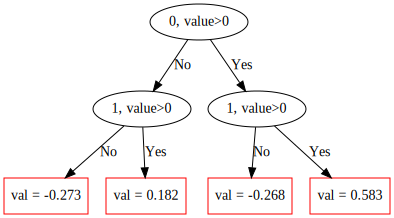

In [7]:
#Training a symmetric decision tree
dt_symmetric=CatBoostRegressor(loss_function='RMSE',num_trees=1,depth=2,random_seed=1,verbose=False)
dt_symmetric.fit(X,y)


#The model as a dictionary, capturing leaf weights and splits.
dt_symmetric.save_model('mini_Regressor',format='json')
f=open('mini_Regressor')
dictionary=json.load(f)

try:
    os.remove('mini_Regressor')
except:    
    PermissionError
    
print('A dictionary describing the symmetric tree:\n',dictionary['oblivious_trees'][0])
#The split that appears at the end has occured the first. So here the symmetric tree first splits w.r.t. X_0
#and then w.r.t. X_1.

#Leaf values are different from the predicted values c1,c2 etc. which are given by scale*(leaf value)+bias.
#The scale is 1 in this case and so the bias amounts to translation which does not affect Shapley values.
print('\nScale and Bias:',dt_symmetric.get_scale_and_bias())

#Visualizing the tree
dt_symmetric.plot_tree(tree_idx=0)

We next compute the path-dependent TreeSHAP feature attributions directly. 

In [8]:
y_pred=dt_symmetric.predict(X)

#Computing TreeSHAP feature attributions directly. 
p1=0.55            #(=p1l+p1r)
p1l=0.3            #(the probability of ending up at the bottom left square)
p1r=0.25           #(the probability of ending up at the bottom right square)
p2=0.3             #(the probability of ending up at the top left square)
p3=0.15            #(the probability of ending up at the top right square)
c1=np.average(y_pred[:55])               
c2=np.average(y_pred[55:85])              
c3=np.average(y_pred[85:])              
mean=p1*c1+p2*c2+p3*c3

def TreeSHAP_symmetric(X):                            #Computing TreeSHAP feature attribution for X_1 directly
    if X[1]<0 and X[0]<0:                             #(Compare with Table 1 in the paper.)
        difference=(p2/(p1l+p2))*(c2-c1)                   
    elif X[1]<0 and X[0]>0:
        difference=(p3/(p1r+p3))*(c3-c1)
    elif X[0]<0:
        difference=(p1l/(p1l+p2))*c1+(p2/(p1l+p2))*c2-(p1l+p2)*c2-(p1r+p3)*c3
    else:
        difference=(p1r/(p1r+p3))*c1+(p3/(p1r+p3))*c3-(p1l+p2)*c2-(p1r+p3)*c3
    return 0.5*(difference+dt_symmetric.predict(X.reshape(1,2))-mean)     



Comparing the output of SHAP package with our direct computation for the symmetric tree.

In [9]:
sample=np.asarray((2*random.random()-1,2*random.random()-1))
print('Sample point:',sample)

#path-dependent TreeSHAP
explainer=shap.TreeExplainer(dt_symmetric,feature_perturbation='tree_path_dependent')
print(f'\npath-dependent attribution for X_0 at the sample point:\nfrom the package: {explainer.shap_values(sample.reshape(1,2))[0][0]}, computed directly: {TreeSHAP_symmetric(sample)[0]}')


Sample point: [0.43853854 0.71121135]

path-dependent attribution for X_0 at the sample point:
from the package: 0.14949269521400912, computed directly: 0.14866255940770456
